In [477]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [478]:
# Standart Libraries

import numpy as np

# Import files

import utilities
from Filter import ExtendedKalmanFilter
from Radar import Radar
from RadarSystem import RadarSystem
from Earth import Earth
from Satellite import Satellite
from SatelliteState import SatelliteState

from config import config


In [494]:
# Initialize Earth
earth = Earth()


# Initialize RadarSystem
# Beijing Aerospace Command and Control Center

BACC =  RadarSystem(200, Earth()) 


# Initialize Satellite
R = config['satellite']['initial_conditions']['distance']
theta = config['satellite']['initial_conditions']['polar_angle']
phi = config['satellite']['initial_conditions']['azimuthal_angle']

phi = config['satellite']['initial_conditions']['polar_angle']
theta = config['satellite']['initial_conditions']['azimuthal_angle']


angular_vel = 0.0010830807404
tang_vel = angular_vel * R
radial_velocity = 0
angular_velocity = 0


sat_state = SatelliteState(np.array([R, theta, phi]), np.array([0]), np.array([radial_velocity, tang_vel, angular_velocity]), np.array([0]))
tiagong = Satellite(sat_state, 0, earth=earth)

In [495]:
R

6778136

In [496]:
# Initialize the Kalman Filter
# tianhe is the chinese super computer

mean_0 = np.array([earth.re+380000, 0, 0.1, np.pi/2, angular_vel, 0.00001])
cov_0 = 10000*np.eye(6)
observation_noise = np.array([[10000,0],[0, 0.0001]])

tianhe = ExtendedKalmanFilter(mean_0, cov_0, earth, observation_noise=observation_noise, process_noise=0.1*np.eye(6))


In [497]:
n = 10000000
simulation = tiagong.simulate(10000000)

sim_lenght = len(simulation.y[0])


In [498]:
simulation.y[0]

array([6778136.        , 6778135.63759344, 6778134.55037241,
       6778132.73833286, 6778130.20146804, 6778126.93976847,
       6778122.95322199, 6778118.24181369, 6778112.805526  ,
       6778106.6443386 , 6778099.75822849, 6778092.14716997,
       6778083.8111346 , 6778074.75009128, 6778064.96400617,
       6778054.45284273, 6778043.21656172, 6778031.2551212 ,
       6778018.5684765 , 6778005.15658028, 6777991.01938246,
       6777976.15683027, 6777960.56886823, 6777944.25543816,
       6777927.21647917, 6777909.45192767, 6777890.96171734,
       6777871.74581005, 6777851.80435616, 6777831.1373212 ,
       6777809.74462317, 6777787.62617733, 6777764.7818962 ,
       6777741.21168958, 6777716.91546453, 6777691.89312537,
       6777666.14457367, 6777639.66970831, 6777612.46842539,
       6777584.54061831, 6777555.88617771, 6777526.5049915 ,
       6777496.39694487, 6777465.56192026, 6777433.99979738,
       6777401.71045322, 6777368.69376201, 6777334.94959526,
       6777300.47782174,

In [499]:
simulation.y.T

array([[ 6.77813600e+06,  0.00000000e+00,  1.57079633e+00,
         7.34126856e+03],
       [ 6.77813564e+06, -7.24813269e-01,  1.57187941e+00,
         7.34126816e+03],
       [ 6.77813455e+06, -1.44962924e+00,  1.57296249e+00,
         7.34126699e+03],
       ...,
       [ 6.38178464e+06, -1.23814135e+03,  2.54752718e+00,
         7.56262280e+02],
       [ 6.38054165e+06, -1.24785396e+03,  2.54763650e+00,
         6.41098423e+02],
       [ 6.37928892e+06, -1.25759219e+03,  2.54772896e+00,
         5.40913489e+02]])

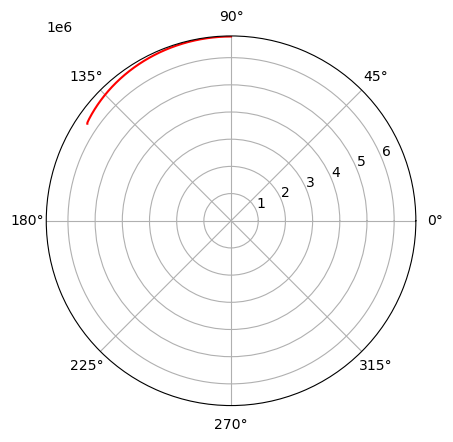

In [500]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d

#n=np.argmin(np.abs(sol.y[0]-earth_radius))

R = simulation.y[0][:]
rad = simulation.y[2][:]
Phi = [np.pi/2 for i in rad]

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(rad, R, c='r')

plt.show()

In [501]:
from copy import deepcopy

In [502]:
m = deepcopy(mean_0)

In [503]:
predicted_states_satellite_cord = [m]

In [504]:
predicted_states_satellite_cord

[array([6.75813660e+06, 0.00000000e+00, 1.00000000e-01, 1.57079633e+00,
        1.08308074e-03, 1.00000000e-05])]

In [505]:
for i in range(sim_lenght):
    

    current_state_satellite_cord = tiagong.get_position_at_t(i)
    current_state_earth_cord = utilities.spherical_to_spherical(current_state_satellite_cord)
    noise_states_earth_cord = BACC.try_detect_satellite(current_state_earth_cord, i)
    print(len(noise_states_earth_cord))

    #print(len(noise_states_earth_cord))
    if len(noise_states_earth_cord) > 0:
        #print("Enter")
        flag = 0
        for state_earth_cord in noise_states_earth_cord:
            #print("Update0")
            state_satellite_cord = utilities.spherical_to_spherical(state_earth_cord.pos)
            new_state_satellite_cord = tianhe.update(state_satellite_cord[:2])

            #if flag == 0:
            #    print(utilities.spherical_to_spherical(state_satellite_cord))
            
    forecast = tianhe.forecast()
    new_state_satellite_cord = [forecast[0][0][0], forecast[0][3][0]]

    predicted_states_satellite_cord += new_state_satellite_cord,



0
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
200
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


KeyboardInterrupt: 

In [491]:
predicted_states_satellite_cord

[array([6.75813660e+06, 0.00000000e+00, 1.00000000e-01, 1.57079633e+00,
        1.08308074e-03, 1.00000000e-05]),
 [6758136.6, 1.5718794075352966],
 [6758136.699999999, 1.5729724882756966],
 [6758136.147368777, 1.5740655690160843],
 [6794088.774828325, 1.3019594621591368],
 [6806009.8742916, 1.0298733549792543],
 [7320894.503526564, 0.7577872474144398],
 [6272302.170560783, 1.6256690072577702],
 [5121932.517011505, 1.6740432876663986],
 [3986230.364117833, 1.7224175680637919],
 [6699935.788625675, 1.594090849659978],
 [6617500.648748568, 1.6076376484944908],
 [6536286.172960634, 1.6211844473280619],
 [6781222.128016742, 1.5777923846502122],
 [6782072.016474565, 1.5717914705998035],
 [6783157.435210959, 1.5657905565492076],
 [6776887.5097774975, 1.58900612915984],
 [6775305.574371918, 1.5909697190592689],
 [6773741.0893155, 1.5929333089586775],
 [6777996.612904618, 1.5918808718653077],
 [6777984.698929571, 1.5934699618117496],
 [6777981.224441881, 1.5950590517581784],
 [6777964.53229020

In [492]:
R2, rad2 = np.array(predicted_states_satellite_cord[1:]).T
Phi = [np.pi/2 for i in rad]

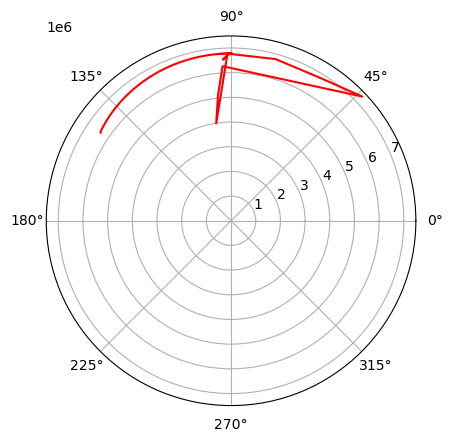

In [493]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d


fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(rad, R, c='r')
ax.plot(rad2, R2, c='r')

plt.show()